In [132]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types_lab9 import CMD
import time
import numpy as np
LOG.propagate = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [296]:
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-04-15 16:37:13,326 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:04:26:a3:64
2025-04-15 16:37:16,305 | INFO     |: Connected to c0:81:04:26:a3:64


In [242]:
ble.disconnect()

Exception: Not connected to a BLE device

In [247]:
ble.send_command(CMD.PING, "")
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

PONG


In [297]:
ble.send_command(CMD.SET_PID_GAINS, "2.5|0.02|0.7")

In [298]:
ble.send_command(CMD.START_PID, "")

In [299]:
ble.send_command(CMD.STOP_PID, "")

In [ ]:
results = []
# ble.stop_notify(ble.uuid['RX_STRING'])
def notification_handler(uuid, byte_array):
    time, imu, pwm, tof= ble.bytearray_to_string(byte_array).split('|')
    results.append([float(time), float(imu), int(pwm), float(tof)])


ble.start_notify(ble.uuid['RX_STRING'], notification_handler)
ble.send_command(CMD.SEND_PID_DATA, "")

In [203]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [301]:
print(results)

[[24897.0, 0.0, 0, 386.0], [39530.0, 22.0, -21, 428.0], [46263.0, 47.0, -23, 605.0], [54272.0, 72.0, -21, 1059.0], [61998.0, 97.0, -16, 2006.0], [66967.0, 122.0, -14, 884.0], [71146.0, 147.0, -24, 3444.0], [77763.0, 172.0, -17, 3189.0], [82673.0, 197.0, -10, 1683.0], [86456.0, 222.0, -10, 600.0], [88833.0, 247.0, -14, 397.0], [91966.0, 272.0, -13, 346.0], [95240.0, 297.0, -10, 377.0], [99852.0, 322.0, -13, 510.0], [102597.0, 347.0, -10, 435.0], [103713.0, 357.0, -41, 408.0]]


In [302]:
import csv
import datetime

# Generate filename with timestamp to avoid overwriting
angle = '(5,-3)'
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"robot_data_{timestamp}_{angle}.csv"

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write header
    csvwriter.writerow(['Time (ms)', 'IMU', 'PWM', 'TOF'])
    # Write all data rows
    csvwriter.writerows(results)

print(f"Data saved to {filename}")

Data saved to robot_data_20250415_163853_(5,-3).csv


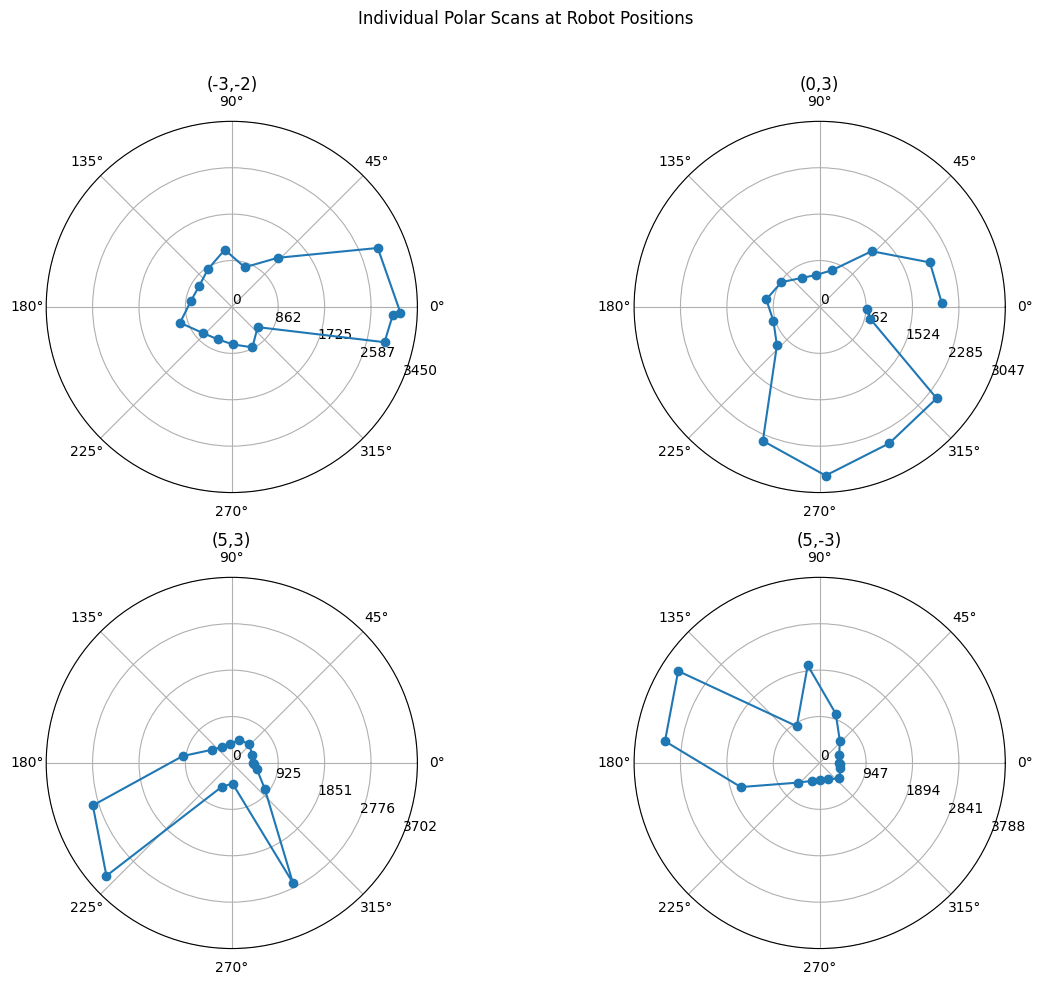

In [72]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import re

# List of CSV file names
file_names = [
    "robot_data_20250415_161708_(-3,-2).csv", "robot_data_20250415_163113_(0,3).csv", "robot_data_20250415_163238_(5,3).csv", "robot_data_20250415_163853_(5,-3).csv"]

# Store all room coordinates {filename: [[x1, y1], [x2, y2], ...]}
all_room_coords = {}

# Set up 2x2 subplot grid for polar plots
fig_polar, axes_polar = plt.subplots(
    2, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 10))
axes_polar = axes_polar.flatten()

# Regex to extract coordinates from filename
coord_pattern = re.compile(r"_\((-?\d+),(-?\d+)\)\.csv$")

# Loop through files and axes
for idx, (filename, ax) in enumerate(zip(file_names, axes_polar)):
    # Extract robot position from filename
    match = coord_pattern.search(filename)
    if match:
        x_robot, y_robot = map(int, match.groups())
        coord_str = f"({x_robot},{y_robot})"
    else:
        x_robot, y_robot = 0, 0 # Default if pattern doesn't match
        coord_str = "Unknown Pos"

    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        results = [[float(x) for x in row] for row in reader]

    imu_angles_deg = np.array([row[1] for row in results])
    tof_readings = np.array([row[3] for row in results])
    imu_angles_rad = np.radians(imu_angles_deg)

    ax.plot(imu_angles_rad, tof_readings, 'o-')
    ax.set_rmax(max(tof_readings) * 1.1)
    ax.set_rticks(np.linspace(0, ax.get_rmax(), 5))
    ax.set_rlabel_position(-22.5)
    ax.grid(True)
    ax.set_title(coord_str, va='top', y=1.1)

# Adjust layout and save polar plots
fig_polar.suptitle("Individual Polar Scans at Robot Positions")
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent title overlap
plt.savefig("combined_polar_plots.png")
plt.show()

In [106]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
def plt_polar(file_name, color, offset=0):
    l_sensor_mm = 70.0                                  
    imu_deg = []                                       
    tof_mm = []                                       
    with open(file_name, newline="") as f:
        reader = csv.reader(f)
        next(reader)                                    
        for t, imu, pwm, tof in reader:
            imu_deg.append(float(imu)+offset)
            tof_mm.append(float(tof))
    imu_rad = np.radians(imu_deg)                       

    global_x = []
    global_y = []
    for θ, r in zip(imu_rad, tof_mm):
        d = r + l_sensor_mm                              
        global_x.append((d * math.cos(θ)) / 1000.0)     
        global_y.append((d * math.sin(θ)) / 1000.0)
    coord_str = file_name.split("(")[-1].split(")")[0]
    fig = plt.figure(figsize=(10, 10))
    ax_polar = fig.add_subplot(1, 2, 1, projection="polar")
    ax_cart = fig.add_subplot(1, 2, 2)
    ax_polar.plot(imu_rad, tof_mm, "o-", color=color)
    ax_polar.set_rmax(max(tof_mm) * 1.1)
    ax_polar.set_rticks(np.linspace(0, ax_polar.get_rmax(), 5))
    ax_polar.set_rlabel_position(-22.5)                  # avoid overlap
    ax_polar.grid(True)
    ax_polar.set_title(coord_str, va="top", y=1.1)
    # --- Cartesian subplot (global frame) ---
    ax_cart.scatter(global_x, global_y, marker="o", color=color)
    ax_cart.set_aspect("equal", adjustable="box")
    ax_cart.set_xlabel("X (m)")
    ax_cart.set_ylabel("Y (m)")
    ax_cart.set_title("Global Frame")

    plt.tight_layout()
    plt.show()

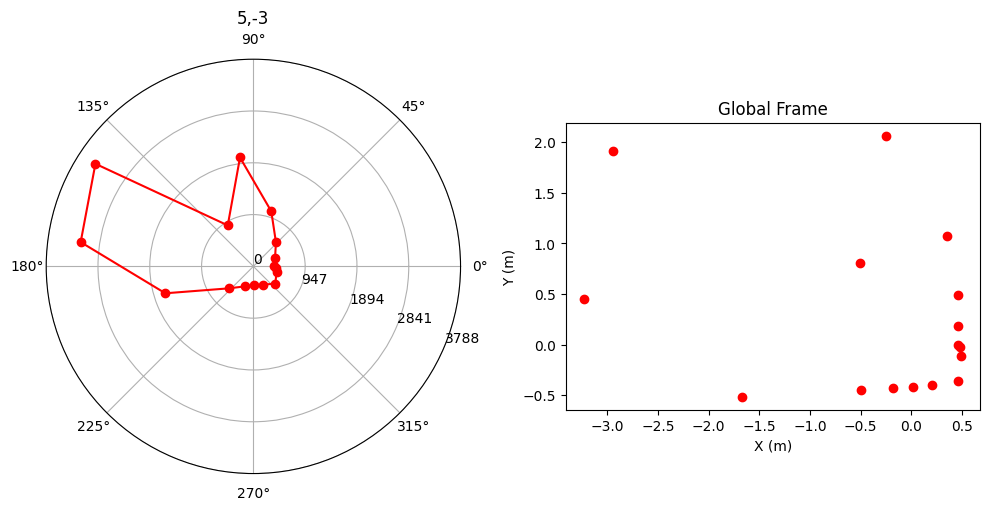

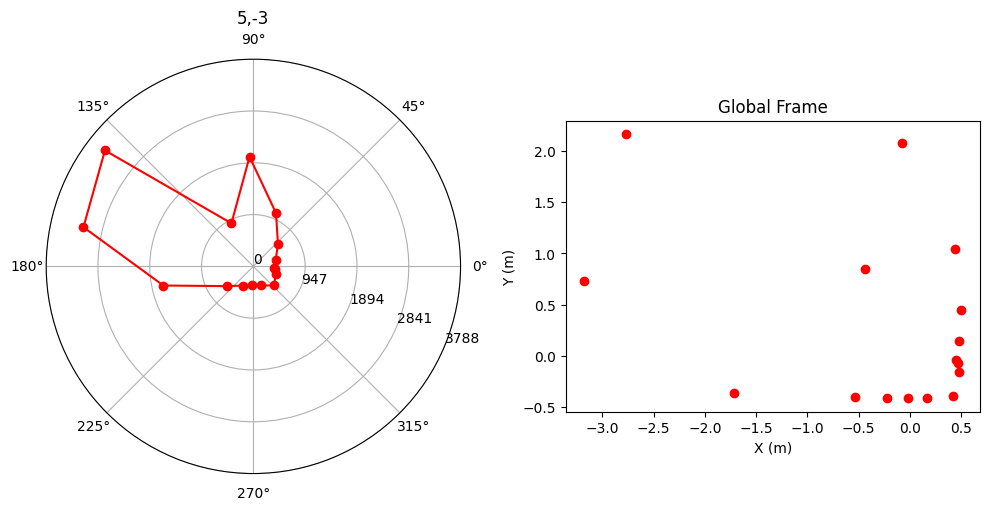

In [116]:
file_names = [
    "robot_data_20250415_161708_(-3,-2).csv", "robot_data_20250415_163113_(0,3).csv", "robot_data_20250415_163238_(5,3).csv", "robot_data_20250415_163853_(5,-3).csv"]
colors = ['r', 'g', 'b', 'c']
# for filename in file_names:
#     plt_polar(filename, colors[file_names.index(filename)])
plt_polar("robot_data_20250415_163853_(5,-3).csv", 'r', 0)
plt_polar("robot_data_20250415_163853_(5,-3).csv", 'r', -5)

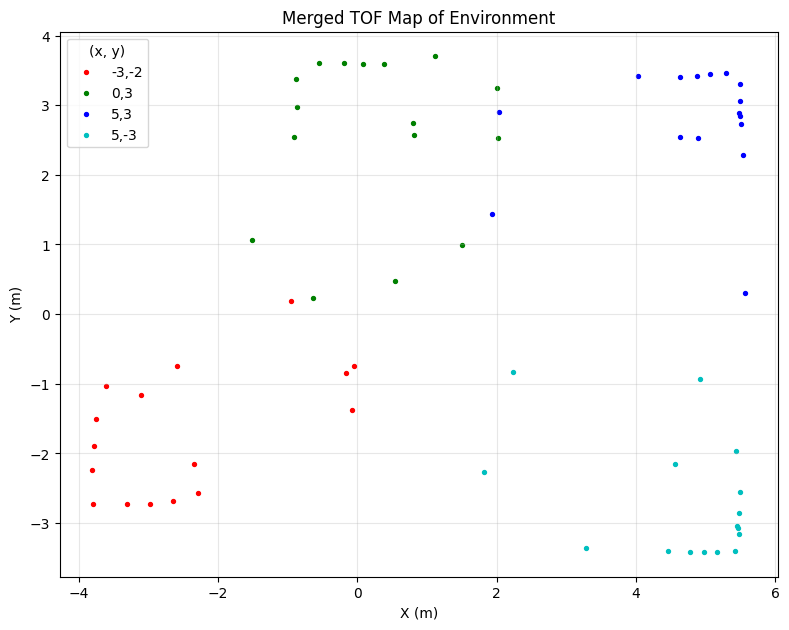

In [176]:
#!/usr/bin/env python3
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

L_SENSOR_MM = 70.0                                # distance sensor‑→robot origin


def global_points(fname, offset=0):
    """Return 2×N array with [x_i, y_i] points in metres for one CSV file."""
    # 1) read IMU angles (deg) and TOF ranges (mm)
    imu_deg, tof_mm = [], []
    with open(fname, newline="") as f:
        rdr = csv.reader(f)
        next(rdr)                                 # skip header
        for _, imu, _, tof in rdr:
            imu_deg.append(float(imu)+offset)
            tof_mm.append(float(tof))

    imu_rad = np.radians(imu_deg)
    ranges = np.array(tof_mm) + L_SENSOR_MM

    # 2) local sensor frame → robot frame (metres)
    x_local = (ranges * np.cos(imu_rad)) / 1000.0
    y_local = (ranges * np.sin(imu_rad)) / 1000.0

    # 3) robot frame → global frame (metres)
    pose_str = fname.split("(")[-1].split(")")[0]     # "-3,-2"
    x_r, y_r = map(float, pose_str.split(","))
    x_global = x_r + x_local
    y_global = y_r + y_local
    return x_global, y_global, pose_str                   # pose_str becomes legend


# ---------- main ----------
file_names = [
    "robot_data_20250415_161708_(-3,-2).csv",
    "robot_data_20250415_163113_(0,3).csv",
    "robot_data_20250415_163238_(5,3).csv",
    "robot_data_20250415_163853_(5,-3).csv",
]
colors = ["r", "g", "b", "c"]
offsets =[25, -15, -15, -5]
plt.figure(figsize=(8, 8))
for fname, c, offset in zip(file_names, colors, offsets):
    xs, ys, lbl = global_points(fname, offset)
    plt.scatter(xs, ys, s=8, color=c, label=lbl)

plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Merged TOF Map of Environment")
plt.legend(title="(x, y)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("env_map.png", dpi=300)
plt.show()

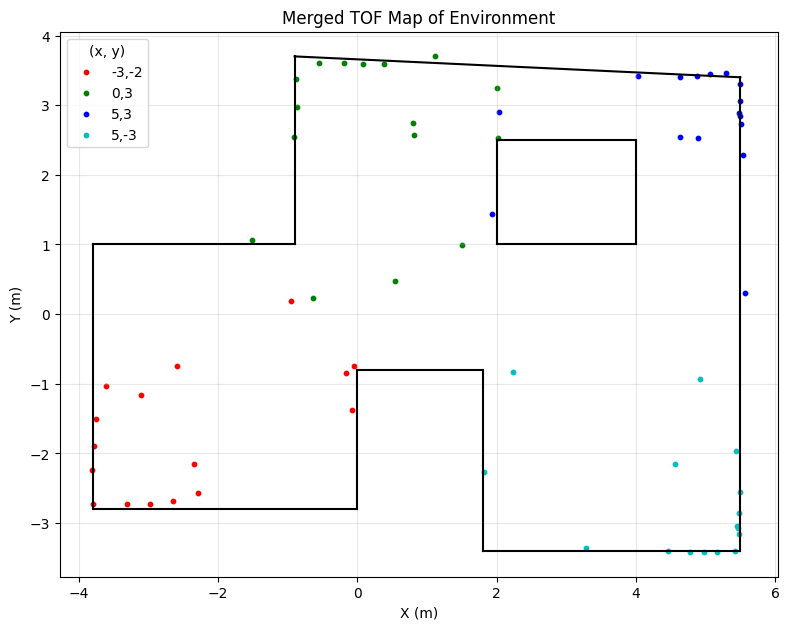

In [260]:
# ---------- main ----------
file_names = [
    "robot_data_20250415_161708_(-3,-2).csv",
    "robot_data_20250415_163113_(0,3).csv",
    "robot_data_20250415_163238_(5,3).csv",
    "robot_data_20250415_163853_(5,-3).csv",
]
colors = ["r", "g", "b", "c"]
offsets = [25, -15, -15, -5]

plt.figure(figsize=(8, 8))
for fname, c, off in zip(file_names, colors, offsets):
    xs, ys, lbl = global_points(fname, off)
    plt.scatter(xs, ys, s=10, color=c, label=lbl)

# ── walls & obstacles ───────────────────────────────────────────────────────────
lines_to_add = [
    ((1.8, -3.4), (5.5, -3.4)),   # bottom 
    ((5.5, -3.4), (5.5,  3.4)),  # right  
    ((5.5,  3.4), (-0.9,  3.7)),  # top  
    ((-0.9,  3.7), (-0.9,  1.0)),  # step‑down
    ((-3.8,  1.0), (-0.9,  1.0)),  # leftward shelf 
    ((0.0,  -0.8), (0.0, -2.8)),  # left wall
    ((-3.8, -2.8), (-0.0, -2.8)),  # bottom run to doorway
    ((-3.8, -2.8), (-3.8, 1.0)),  # doorway leg L
    ((0.0, -0.8), (1.8, -0.8)),  # doorway lintel
    ((1.8, -0.8), (1.8, -3.4)),  # doorway leg R

    # ── square interior obstacle ──
    ((2.0,  1.0), (4.0,  1.0)),  # bottom   (shifted up to y = 1)
    ((4.0,  1.0), (4.0,  2.5)),  # right
    ((4.0,  2.5), (2.0,  2.5)),  # top
    ((2.0,  2.5), (2.0,  1.0)),  # left
]

for (p0, p1) in lines_to_add:
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]], "k")

plt.gca().set_aspect("equal", "box")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Merged TOF Map of Environment")
plt.legend(title="(x, y)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("env_map.png", dpi=300)
plt.show()

In [ ]:
# 